# Previsione a 14 giorni

Previsione a 14 giorni con modelli SARIMA e Grandient Boosting.

> Max Pierini

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

In [1]:
# REFERENCES
#
# https://www.youtube.com/watch?v=Y2khrpVo6qI
# https://www.lorenzogovoni.com/modello-arima/
# https://otexts.com/fpp2/seasonal-arima.html
# https://otexts.com/fpp2/non-seasonal-arima.html
# http://people.duke.edu/~rnau/seasarim.htm
# https://robjhyndman.com/hyndsight/monthly-seasonality/
# http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima
# http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA.predict
# https://www.datageeko.com/time-series-from-arima-to-deep-learning-part-1/
# http://www.phdeconomics.sssup.it/documents/Lesson13.pdf
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab
# https://www.youtube.com/watch?v=Y2khrpVo6qI

In [2]:
import numpy as np
import pandas as pd
#import itertools
#from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import pmdarima as pa

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import scipy.stats as sps

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)

In [4]:
df.index = df.index.normalize()

In [5]:
ts = df[['nuovi_positivi']].dropna()

In [6]:
sts = ts.nuovi_positivi
sts.index.name = None

In [7]:
ts_log = np.log(sts).dropna()

In [8]:
auto_sarima_params = {
 'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False
}

In [9]:
arima_model = pa.arima.ARIMA(
    **auto_sarima_params
)
arima_model_fit = arima_model.fit(ts_log)

I nuovi casi giornalieri previsti a 14 giorni sono stimati utilizzando un modello di autoregressione SARIMA ovvero $\mathrm{ARIMA}(p,d,q)(P,D,Q)[s]$ sul logaritmo dei nuovi positivi, i cui parametri ottimali sono stati determinati per grid-search (vedi oltre per dettagli).

In modello migliore è attualmente

$$
\mathrm{ARIMA}(1, 1, 2)(1, 0, 1)[7]
$$

I parametri potrebbero essere ulteriormente affinati con successive grid-search mirate.

I nuovi casi ad un giorno sono stimati anche con modello ad albero decisionale [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) in Supervised Machine Learning (**GBR-SML**) con `scikit-learn`, basato sull'osservazione dei nuovi positivi dei 28 giorni precedenti e i cui iperparametri ottimali sono stati determinati per grid-search cross-validation. Gli iperparametri potrebbero essere ulteriormente affinati grazie a successive grid-search mirate.

In [10]:
predict_past_log, predict_past_ci_log = arima_model_fit.predict_in_sample(alpha=.5, return_conf_int=True)

In [11]:
predict_past = np.exp(predict_past_log)

In [12]:
predict_past_ci = np.exp(predict_past_ci_log)

In [13]:
predict_future_log, predict_future_ci_log = arima_model_fit.predict(n_periods=15, alpha=.5, return_conf_int=True)

In [14]:
predict_future, predict_future_ci = np.exp(predict_future_log), np.exp(predict_future_ci_log)

In [15]:
predict_future_X = pd.date_range(
    start=ts.index[-1] + pd.Timedelta(days=1),
    end=ts.index[-1] + pd.Timedelta(days=15)
)

In [16]:
features_n = 7 * 4
DF = pd.DataFrame(
    columns=[f'day_{i}' for i in range(features_n + 1)],
    index=ts.index[features_n:]
)
for i in range(features_n + 1):
    _df = ts.iloc[i:(ts.index.size - features_n + i)]
    DF.iloc[:,i] = _df.values

In [17]:
X = DF.iloc[:,:features_n]
y = DF.iloc[:,-1].values

In [18]:
mdl_params = {
    'alpha': 0.5, 
    'criterion': 'friedman_mse', 
    'learning_rate': 0.45, 
    'loss': 'quantile', 
    'max_depth': 2, 
    'min_samples_split': 7, 
    'n_estimators': 100
}
_ = """
{
 'alpha': 0.5,
 'criterion': 'friedman_mse',
 'learning_rate': 0.5,
 'loss': 'quantile',
 'max_depth': 3,
 'min_samples_split': 5,
 'n_estimators': 500
}"""

In [19]:
mdl = GradientBoostingRegressor(
    **mdl_params
)

In [20]:
GBR_params = mdl.get_params()

In [21]:
iterations = 50

y_trains = []
y_trains_pred = []
y_tests = []
y_tests_pred = []
RMSE = []
R2_train = []
R2_test = []
train_scores = []
test_scores = []
futures = []
futures_25 = []
futures_75 = []
feature_importances = []
permutation_imps = []

np.random.seed(42)
random_states = np.random.choice(range(5000), iterations, replace=False)

for i in range(iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1)

    mdl = GradientBoostingRegressor(
        **mdl_params
    )
    mdl.set_params(random_state=random_states[i])

    mdl.fit(X_train, y_train)
    y_train_pred = mdl.predict(X_train)
    y_test_pred = mdl.predict(X_test)

    y_trains.append(y_train)
    y_trains_pred.append(y_train_pred)
    y_tests.append(y_test)
    y_tests_pred.append(y_test_pred)

    mse = mean_squared_error(y_test, y_test_pred)
    RMSE.append(np.sqrt(mse))
    #print("The root mean squared error (RMSE) on test set: {:.4f}".format(np.sqrt(mse)))

    R2_train.append(mdl.score(X_train, y_train))
    R2_test.append(mdl.score(X_test, y_test))
    
    n_estimators = mdl.get_params()['n_estimators']
    test_score = np.zeros((n_estimators,), dtype=np.float64)
    for j, y_pred in enumerate(mdl.staged_predict(X_test)):
        test_score[j] = mdl.loss_(y_test, y_pred)
    train_score = mdl.train_score_
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    mdl.fit(X, y)
    future = mdl.predict(DF.iloc[-1, 1:].values.reshape(1, -1))
    futures.append(future)
    
    feature_importance = mdl.feature_importances_
    feature_importances.append(feature_importance)
    
    permutation_imp = permutation_importance(mdl, X, y, n_repeats=10,
                                random_state=random_states[i], n_jobs=-1)
    permutation_imps.append(permutation_imp.importances)
    
    # Caculate 50% quantile loss
    mdl.set_params(alpha=.25)
    mdl.fit(X, y)
    future_25 = mdl.predict(DF.iloc[-1, 1:].values.reshape(1, -1))
    futures_25.append(future_25)

    mdl.set_params(alpha=.75)
    mdl.fit(X, y)
    future_75 = mdl.predict(DF.iloc[-1, 1:].values.reshape(1, -1))
    futures_75.append(future_75)

In [22]:
permutation_imps = np.array(permutation_imps).transpose(1,0,2).reshape(28,-1)

In [23]:
future_fit = sps.norm.fit(np.concatenate((futures_25, futures, futures_75)).ravel())

future_dist = sps.norm(future_fit[0], future_fit[1])

future_x = np.linspace(future_dist.ppf(.0001), future_dist.ppf(.9999))
future_y = future_dist.pdf(future_x)

future_x_50 = np.linspace(future_dist.ppf(.01), future_dist.ppf(.99))
future_y_50 = future_dist.pdf(future_x_50)

future_hi = future_dist.ppf(.99)
future_lo = future_dist.ppf(.01)
future_mu = future_dist.ppf(.5)

X_future = X.index[-1] + pd.Timedelta(days=1)

In [24]:
future_25_mu = np.min(futures_25)
future_75_mu = np.max(futures_75)

# Previsioni

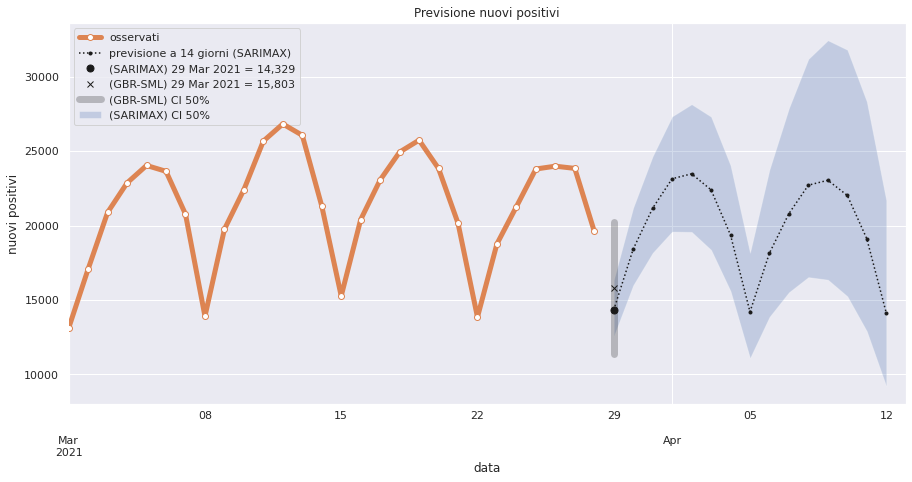

In [25]:
ax = df.iloc[-28:].nuovi_positivi.plot(
    lw=5, marker='o', mfc='w',
    label='osservati', figsize=(15, 7), zorder=100, color='C1'
)
ax.plot(predict_future_X, predict_future, color='k', ls=':', marker='.', label='previsione a 14 giorni (SARIMAX)')
ax.plot(
    predict_future_X[0], predict_future[0], marker='o', ms=7, ls='none', color='k', 
    label=f"(SARIMAX) {predict_future_X[0].date().strftime('%d %b %Y')} = {predict_future[0]:,.0f}")
ax.fill_between(
    predict_future_X, predict_future_ci[:,0], predict_future_ci[:,1],
    alpha=.25, label='(SARIMAX) CI 50%'
)
ax.plot(
    X_future, future_mu, marker='x', color='k', ls='none',
    label=f"(GBR-SML) {X_future.date().strftime('%d %b %Y')} = {future_mu:,.0f}",
)
ax.plot(
    [X_future, X_future], [future_lo, future_hi], color='k', lw=7, alpha=.25,
    label=f"(GBR-SML) CI 50%",
)

ax.set_xlim(ax.get_xlim()[0], predict_future_X[-1] + pd.Timedelta(days=1))
ax.set(
    title=f'Previsione nuovi positivi',
    ylabel='nuovi positivi'
)
ax.legend(loc='upper left')
plt.show()

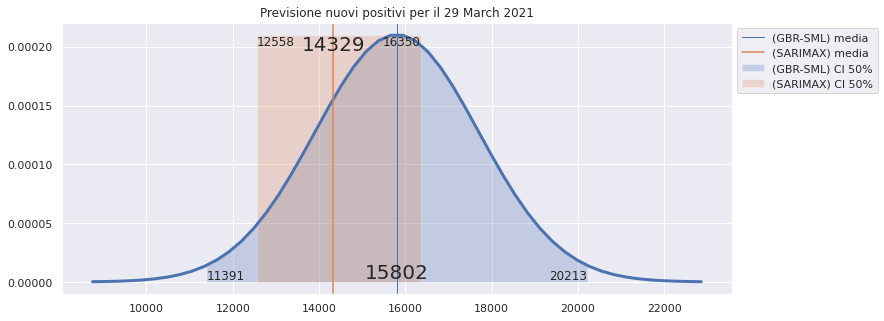

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(future_x, future_y, lw=3)
ax.fill_between(
    future_x_50,
    future_y_50,
    alpha=.25, label='(GBR-SML) CI 50%'
)
ax.axvline(future_mu, color='C0', lw=1,  label='(GBR-SML) media')

ax.axvline(predict_future[0], color='C1', label='(SARIMAX) media')
ylim = ax.get_ylim()
ax.fill_betweenx(
    [0, future_y.max()],
    predict_future_ci[0,0], predict_future_ci[0,1],
    alpha=.25, label='(SARIMAX) CI 50%'
)
ax.text(future_mu, 0, int(future_mu), ha='center', va='bottom', fontsize=20)
ax.text(future_lo, 0, int(future_lo), ha='left', va='bottom')
ax.text(future_hi, 0, int(future_hi), ha='right', va='bottom')

ax.text(predict_future[0], future_y.max(), int(predict_future[0]), ha='center', va='top', fontsize=20)
ax.text(predict_future_ci[0,0], future_y.max(), int(predict_future_ci[0,0]), ha='left', va='top')
ax.text(predict_future_ci[0,1], future_y.max(), int(predict_future_ci[0,1]), ha='right', va='top')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set(
    ylim=ylim,
    title=f'Previsione nuovi positivi per il {X_future.strftime("%d %B %Y")}',
)
plt.show()

# Metodo

## SARIMA

I modelli ARIMA vengono solitamente scritti in forma semplificata

$$
\mathrm{ARIMA}(p,d,q)(P,D,Q)[s]
$$

dove 

- $(p,d,q)$ sono rispettivamente gli iperparametri di auto regressione (AR), derivata (I) e media mobile (MA) della porzione non stagionale

- $(P,D,Q)[s]$ sono rispettivamente gli iperparametri di auto regressione (AR), derivata (I) e media mobile (MA) della porzione con stagionalità $s$

e che in forma di operatori polinomiali corrisponde a

$$
\phi_p(B)\Phi_P(B^s)(1-B)^d(1-B^s)^D x_t = \theta_q(B) \Theta_Q (B^s) \varepsilon_t
$$

in cui

- $x_t$ è l'osservazione della variabile $x$ al tempo $t$

- $\varepsilon_t$ è il rumore bianco $\varepsilon$ al tempo $t$ ed è [indeticamente e indipentemente distribuito](https://online.stat.psu.edu/stat510/lesson/2/2.1) normale con media 0 e varianza $\sigma^2$ ovvero $\varepsilon \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)$

- l'[operatore di back-shift](https://otexts.com/fpp2/backshift.html) $B^i$ è tale per cui $B^i y_t = y_{t-i}$ e pertanto i termini $(1 - B^i)^j y_t$ sono la derivata di ordine $j$ di $y_{t-i}$ infatti dove ad esempio $j=1$ otteniamo $(1 - B^i) y_t = y_{t-i} - y_{t-i-1}$

- gli operatori $\phi_p(\cdot)$ e $\theta_q(\cdot)$ sono rispettavemente operatori polinomiali di autoregressione AR e media mobile MA, di ordine $p$ e $q$, della porzione non stagionale

- gli operatori $\Phi_P(\cdot)$ e $\Theta_Q(\cdot)$ sono rispettavemente operatori polinomiali di autoregressione AR e media mobile MA, di ordine $P$ e $Q$, della porzione stagionale

Un [operatore polinomiale](https://link.springer.com/chapter/10.1007%2F978-3-030-63823-8_84) $O_i(B^j)$ corrisponde a

$$
O_i(B^j) = 1 - \sum_{k=1}^{i} O_k B^{kj}
$$

dove $O_k$ è il coefficiente di $B^{kj}$.

Il modello da noi scelto (come vedremo più avanti) corrisponde a 

$$
\mathrm{ARIMA}(1,1,2)(1,0,2)[7]
$$

quindi

$$
\mathrm{ARIMA}(p_{=1},d_{=1},q_{=2})(P_{=1},D_{=0},Q_{=1})[s_{=7}]
$$

Sostituendo $(p,d,q)(P,D,Q)[s]$ nell'equazione a operatori polinomiali otteniamo

$$
\phi_1(B)\Phi_1(B^7)(1-B)^1(1-B^7)^0 x_t = \theta_2(B) \Theta_1 (B^7) \varepsilon_t
$$

che possiamo semplificare in

$$
\phi_1(B)\Phi_1(B^7)(1-B) x_t = \theta_2(B) \Theta_1 (B^7) \varepsilon_t
$$

Svolgendo gli operatori polinomiali AR e MA delle porzioni non stagionale e stagionale otteniamo pertanto il processo

$$
(1- \phi_1 B)(1 - \Phi_1 B^7)(1 - B) x_t = (1 - \theta_1B - \theta_2B^2)(1 - \Theta_1B^7) \varepsilon_t
$$

ovvero

$$
(-\phi_1\Phi_1B^9 + \phi_1\Phi_1B^8 + \Phi_1B^8 - \Phi_1B^7 + \phi_1B^2 - \phi_1B - B + 1) x_t
\\
=
\\
(\theta_1 \Theta_1 B^8 + \theta_2 \Theta_1 B^9 -
\Theta_1 B^7  - \theta_1 B  - \theta_2 B^2  + 1) \varepsilon_t
$$

Espandendo gli operatori di back-shift

$$
-\phi_1\Phi_1x_{t-9} + \phi_1\Phi_1x_{t-8} + \Phi_1x_{t-8} - \Phi_1x_{t-7} + \phi_1x_{t-2} - \phi_1x_{t-1} - x_{t-1} + x_t
\\
=
\\
\theta_1 \Theta_1 \varepsilon_{t-8} + \theta_2 \Theta_1 \varepsilon_{t-9} -
\Theta_1 \varepsilon_{t-7}  - \theta_1 \varepsilon_{t-1}  - \theta_2 \varepsilon_{t-2}  + \varepsilon_{t}
$$

da cui otteniamo l'equazione esplicita

$$
\begin{align*}
x_t & = x_{t-1} \\
 & + \phi_1 x_{t-1} - \phi_1 x_{t-2} \\
 & + \Phi_1 x_{t-7} - \Phi_1 x_{t-8} - \phi_1\Phi_1 x_{t-8} + \phi_1\Phi_1 x_{t-9} \\
 & + \varepsilon_{t} - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2} \\
 & - \Theta_1\varepsilon_{t-7} + \theta_1 \Theta_1 \varepsilon_{t-8} + \theta_2 \Theta_1 \varepsilon_{t-9}
\end{align*}
$$

che possiamo infine semplificare in 

$$
\begin{align*}
x_t  & = x_{t-1} \\
 & + \phi_1 (x_{t-1} - x_{t-2}) \\
 & + \Phi_1 (x_{t-7} -  x_{t-8}) - \Phi_1 \phi_1 (x_{t-8} - x_{t-9}) \\
 & + \varepsilon_{t} - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2} \\
 & - \Theta_1\varepsilon_{t-7} + \Theta_1 ( \theta_1 \varepsilon_{t-8} + \theta_2 \varepsilon_{t-9})
\end{align*}
$$

dove i rumori bianchi $\varepsilon_t$ sono identicamente e indipendentemente distribuiti normali con media 0 e varianza $\sigma^2$, ovvero $\varepsilon_t \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)$.

Abbiamo pertanto solamente 6 coefficienti (vedi [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)).

I coefficienti della porzione non stagionale
- $\phi_1$, coefficiente dell'autoregressione AR, corripondente ad `ar.L1`
- $\theta_1$, coefficiente della media mobile MA, corripondente ad `ma.L1`
- $\theta_2$, coefficiente della media mobile MA, corripondente ad `ma.L2`

I coefficienti della porzione stagionale
- $\Phi_1$, coefficiente dell'autoregressione AR, corripondente ad `ar.S.L7`
- $\Theta_1$, coefficiente della media mobile MA, corripondente ad `ma.S.L7`

La varianza del rumore bianco $\varepsilon_t$
- $\sigma^2$ corripondente a `sigma2`

In [27]:
def get_stationarity(ts, window, mdl):
    # rolling
    r_mu = ts.rolling(window=window, center=True).mean().dropna()
    r_sd = ts.rolling(window=window, center=True).std().dropna()
    r_va = ts.rolling(window=window, center=True).var().dropna()
    exog = ts.values.ravel().reshape(-1, 1)
    resid = mdl.resid()
    #white_test = sms.diagnostic.het_white(mdl.resid, mdl.model.exog)
    bp_test = sms.diagnostic.het_breuschpagan(resid, exog)
    #labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    #print('White Test:\n', dict(zip(labels, white_test)))
    #print('Breusch-Pagan Test:\n', dict(zip(labels, bp_test)))
    sea = seasonal_decompose(ts)
    result = adfuller(ts, autolag='AIC')
    
    fig = plt.figure(constrained_layout=True, figsize=(15, 7))
    gs = GridSpec(2, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1:])
    
    ax30 = fig.add_subplot(gs[1, 0])
    ax31 = fig.add_subplot(gs[1, 1:3])
    #ax32 = fig.add_subplot(gs[1, 2])
    ax33 = fig.add_subplot(gs[1, 3])

    #ax1.plot(r_mu, r_va, marker='o', ls='none', alpha=.5)
    mu_va = pd.DataFrame({'moving average': r_mu.values.ravel(), 'moving variance': r_va.values.ravel(),})
    sns.regplot(
        data=mu_va, x='moving average', y='moving variance',
        line_kws=dict(color='r'), scatter_kws=dict(alpha=.5),
        ax=ax1
    )
    ax1.set(
        title='Finestra 7 giorni',
        xlabel='media mobile', ylabel='varianza mobile'
    )
    ts.plot(
        ax=ax2, label='observations', 
        title=f"Dickey-Fuller test per stazionarietà $p$-value: {result[1]}"
    )
    r_mu.plot(ax=ax2, label='rolling mean')
    r_sd.plot(ax=ax2, label='rolling Std')
    ax2.legend()
    
    ax30.plot(exog, resid, marker='.', alpha=.5, ls='none')
    bp_text = f"{bp_test[-1]:.6f}" if bp_test[-1] > .01 else f"{bp_test[-1]:.6e}"
    ax30.set(
        title=f'Breusch-Pagan $p$-value: {bp_text}',
        xlabel='osservazioni', ylabel='SARIMA residuals'
    )
    
    sea.trend.plot(ax=ax31, title='trend')
    sea.seasonal.plot(ax=ax33, xlim=(sea.seasonal.index[0], sea.seasonal.index[7*4]), title='stagionalità')
    #sea.resid.plot(ax=ax33, marker='.', ls='none', title='residuals')
    
    plt.show()
    # Dickey-Fuller test
    #print("===========> Dickey-Fuller test")
    #result = adfuller(ts, autolag='AIC')
    #print('ADF stat:', result[0])
    #print('p-value:', result[1])
    #print('Used lags:', result[2])
    #print('Observations:', result[3])
    #print('Criticals')
    #for k, v in result[4].items():
    #    print('\t', k, v)

Notiamo tre caratteristiche dei dati di cui è necessario tener conto prima di procedere alla scelta del modello SARIMA:

1. **Eteroschedasticità**: la varianza aumenta all'aumentare della media; il test di Breusch-Pagan infatti ritorna un $p$-value notevolmente inferiore al più alto livello di significatività (0.1)
2. **Non-stazionarietà**: i dati non sono stazionari ma presentano un chiaro trend non lineare; il test di Dickey-Fuller infatti ritorna un $p$-value superiore al più alto livello di significatività (0.1)
3. **Stagionalità**: è chiaramente visibile una variazione ciclica (stagionale) di 7 giorni

I modelli SARIMA possono gestire la non-stazionarietà utilizzando la derivata delle osservazioni (parametro $d$) e la stagionalità tramite i parametri $(P,D,Q)[s]$ ma non possono migliorare l'eteroschedasticità.

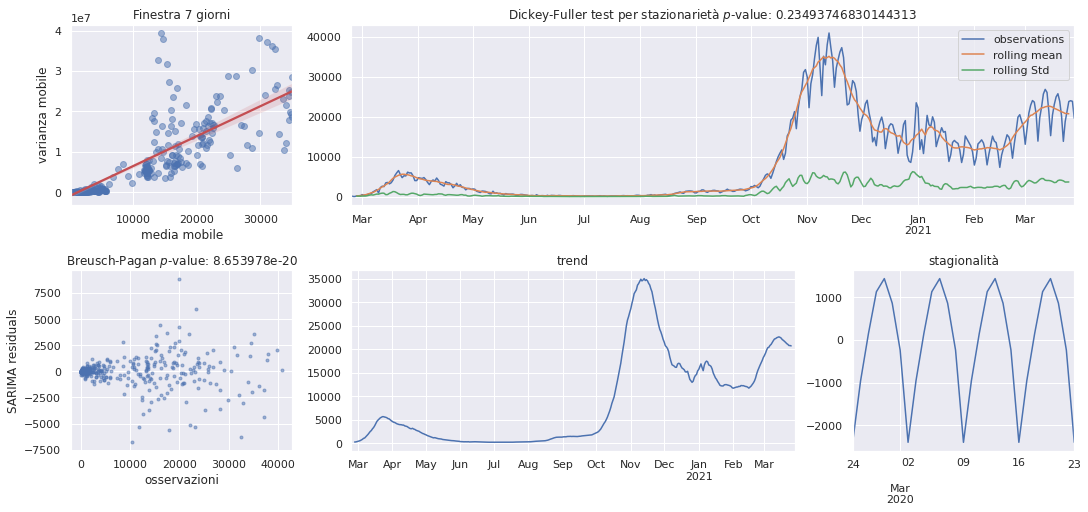

In [28]:
arima_model_ori = pa.arima.ARIMA(
    **auto_sarima_params
)
arima_model_fit_ori = arima_model_ori.fit(sts)
get_stationarity(sts, 7, arima_model_fit_ori)

Per ovviare all'eteroschedasticità, trasformiamo dunque i dati prendendo il logaritmo dei nuovi positivi.

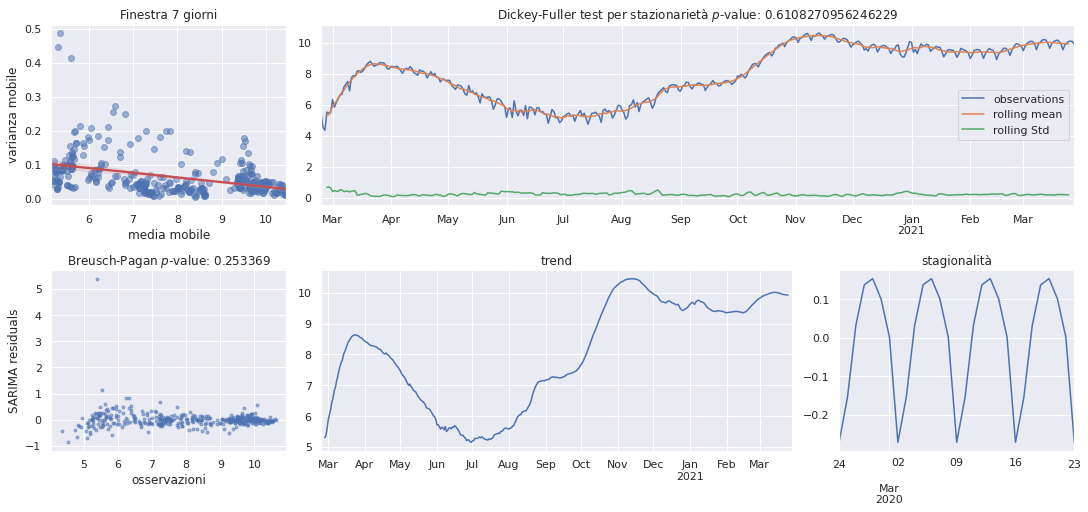

In [29]:
get_stationarity(ts_log, 7, arima_model_fit)

Il test di Breusch-Pagan è ora più che soddifacente, dunque verifichiamo che l'utilizzo della derivata prima delle osservazioni sia in grado di risolvere il trend non lineare.

Come notiamo, il test di Dickey-Fuller sulla derivata prima ritorna un $p$-value è accettabile (minore di 0.01).

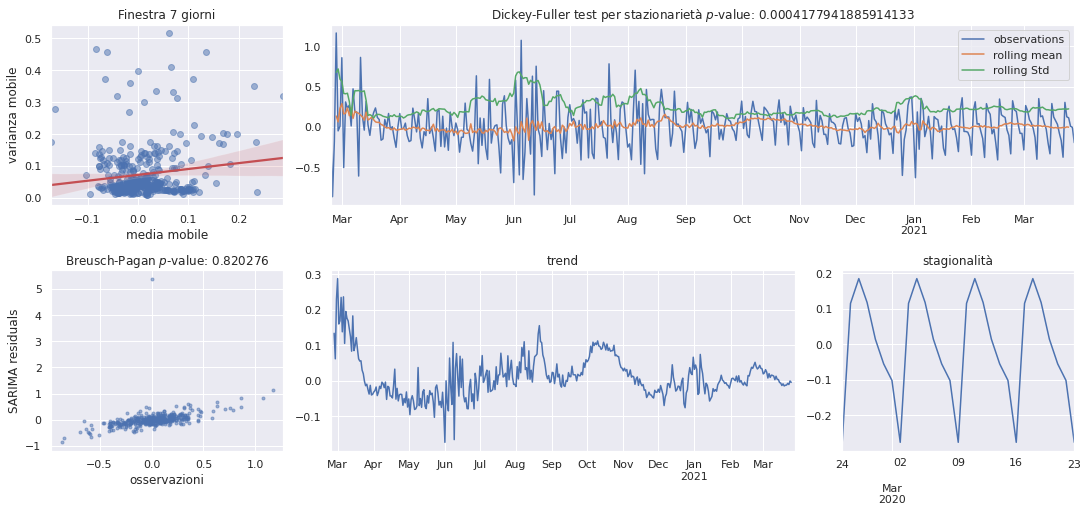

In [30]:
get_stationarity(ts_log.diff().fillna(0), 7, arima_model_fit)

Per il modello SARIMA utilizzeremo pertanto:

- la derivata prima $d=1$ del logaritmo dei nuovi positivi $Y=\log(y)$
- una stagionalità di 7 giorni ($s=7$)

e procederemo alla scelta del miglior modello che minimizzi il Bayesian Information Criterion per grid-search con `pmdarima`.

In [31]:
# codice per riprodurre la grid-search del modello SARIMAX
_ = """
auto_sarima = pa.auto_arima(
    ts_log,
    # ARIMA parameters
    d=1,
    # Seasonal parameters
    seasonal=True, m=7,
    # settings
    information_criterion='bic',
    trace=True,
    maxiter=50,
    suppress_warnings=True,
    alpha=.01,
    with_intercept=False,
    enforce_stationarity=False, 
    enforce_invertibility=False,
)
auto_sarima_params = auto_sarima.get_params()"""

In [32]:
print("""
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=-91.111, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=78.759, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=-29.669, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=7.598, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=22.647, Time=0.16 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=-43.768, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=-85.448, Time=0.82 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=-85.474, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=27.054, Time=0.23 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=-11.985, Time=0.37 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=-69.422, Time=0.28 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=-79.335, Time=1.07 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=-116.824, Time=0.42 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=16.722, Time=0.17 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=-54.235, Time=0.25 sec
 ARIMA(1,1,2)(2,0,1)[7]             : BIC=-110.995, Time=0.69 sec
 ARIMA(1,1,2)(1,0,2)[7]             : BIC=-110.983, Time=0.87 sec
 ARIMA(1,1,2)(0,0,0)[7]             : BIC=69.728, Time=0.08 sec
 ARIMA(1,1,2)(0,0,2)[7]             : BIC=-17.942, Time=0.39 sec
 ARIMA(1,1,2)(2,0,0)[7]             : BIC=-83.396, Time=0.37 sec
 ARIMA(1,1,2)(2,0,2)[7]             : BIC=-105.061, Time=1.12 sec
 ARIMA(0,1,2)(1,0,1)[7]             : BIC=-97.263, Time=0.19 sec
 ARIMA(1,1,1)(1,0,1)[7]             : BIC=-95.694, Time=0.21 sec
 ARIMA(1,1,3)(1,0,1)[7]             : BIC=-112.048, Time=0.61 sec
 ARIMA(0,1,1)(1,0,1)[7]             : BIC=-99.013, Time=0.14 sec
 ARIMA(0,1,3)(1,0,1)[7]             : BIC=-96.402, Time=0.28 sec
 ARIMA(2,1,1)(1,0,1)[7]             : BIC=-96.813, Time=0.27 sec
 ARIMA(2,1,3)(1,0,1)[7]             : BIC=-106.140, Time=0.67 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=-106.650, Time=0.67 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7]          
Total fit time: 12.051 seconds
""")


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7]             : BIC=-91.111, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=78.759, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7]             : BIC=-29.669, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7]             : BIC=7.598, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7]             : BIC=22.647, Time=0.16 sec
 ARIMA(2,1,2)(1,0,0)[7]             : BIC=-43.768, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[7]             : BIC=-85.448, Time=0.82 sec
 ARIMA(2,1,2)(1,0,2)[7]             : BIC=-85.474, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[7]             : BIC=27.054, Time=0.23 sec
 ARIMA(2,1,2)(0,0,2)[7]             : BIC=-11.985, Time=0.37 sec
 ARIMA(2,1,2)(2,0,0)[7]             : BIC=-69.422, Time=0.28 sec
 ARIMA(2,1,2)(2,0,2)[7]             : BIC=-79.335, Time=1.07 sec
 ARIMA(1,1,2)(1,0,1)[7]             : BIC=-116.824, Time=0.42 sec
 ARIMA(1,1,2)(0,0,1)[7]             : BIC=16.722, Time=0.17 sec
 ARIMA(1,1,2)(1,0,0)[7]             : BIC=-54.235, 

In [33]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  399
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood                  79.794
Date:                             Sun, 28 Mar 2021   AIC                           -147.588
Time:                                     17:18:42   BIC                           -123.669
Sample:                                          0   HQIC                          -138.114
                                             - 399                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9467      0.020     47.772      0.000       0.908       0.986
ma.L1         -1.5648      0.036    -43.707      0.000      -1.635      -1.495
ma.L2          0.6456      0.033     19.535      0.000       0.581       0.710
ar.S.L7        0.9754      0.010     99.481      0.000       0.956       0.995
ma.S.L7       -0.7742      0.037    -20.905      0.000      -0.847      -0.702
sigma2         0.0383      0.002     18.905      0.000       0.034       0.042
===================================================================================
Ljung-Box (Q):                       52.62   Jarque-Bera (JB):                91.49
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
arima_model_fit

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

Il modello migliore è molto semplice e con buone caratteristiche.

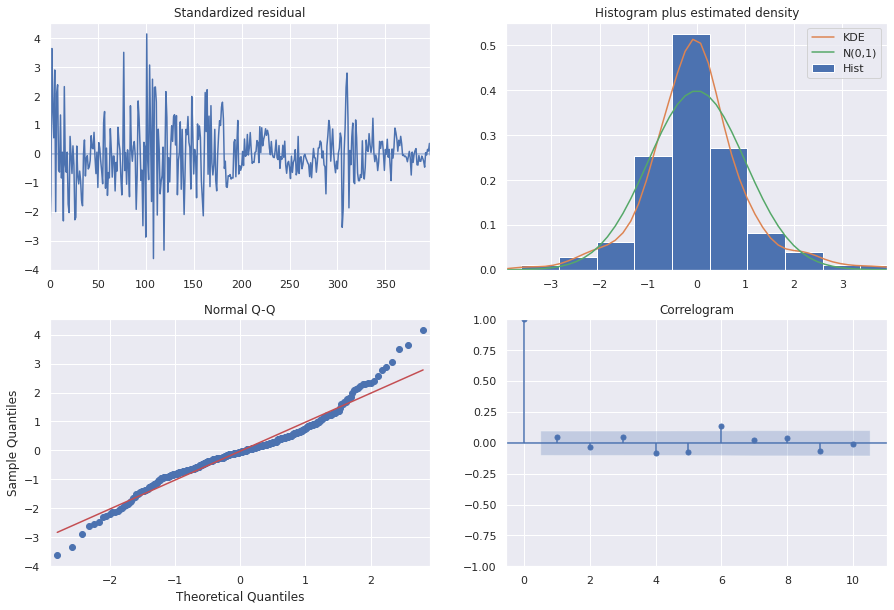

In [35]:
arima_model_fit.plot_diagnostics(figsize=(15,10));

Essendo molti ampi gli intervalli di confidenza delle previsioni, è stato scelto un intervallo del 50% (come per GBR-SML).

In [36]:
#pa.tsdisplay(ts_log_detrend, lag_max=50)

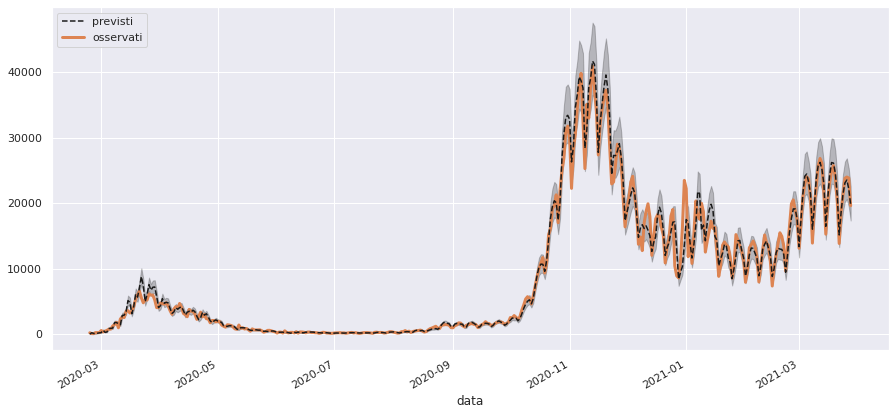

In [37]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(
    ts.index, predict_past,
    #title='Osservati e previsti, modello SARIMAX',
    ls='--', zorder=100,
    color='k', label='previsti',
    #ylabel='nuovi positivi'
)
ax.fill_between(
    ts.index[1:],
    predict_past_ci[1:,0], predict_past_ci[1:,1],
    alpha=.25, color='k'
)
df.nuovi_positivi.plot(ax=ax, lw=3, label='osservati', color='C1')
ax.legend(loc='upper left')
plt.show()

In [38]:
sarimax_R2 = r2_score(ts.nuovi_positivi.values, predict_past)

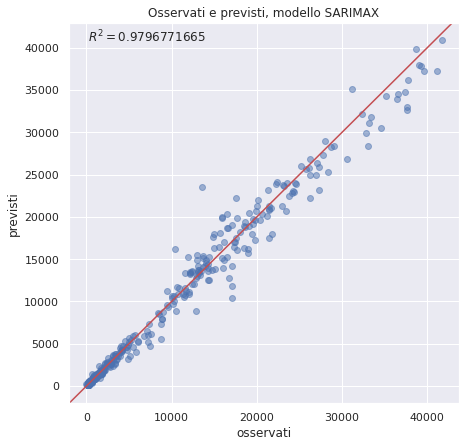

In [39]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    predict_past, ts.nuovi_positivi.values,
    marker='o', ls='none', alpha=.5
)
ax.axline(xy1=(0, 0), slope=1, color='r')
ax.text(
    .05, .95,
    f"$R^2 = {sarimax_R2:.10f}$",
    transform=ax.transAxes
)
ax.set(
    xlabel='osservati',
    ylabel='previsti',
    title='Osservati e previsti, modello SARIMAX'
)
plt.show()

## Gradient Boosting

Il Gradient Boosting Regressor in Supervised Machine Learning (GBR-SML) è un modello di regressione ad albero decisionale.

Nella forma attuale, il modello è sfruttato come autogressione e utilizza come target (variabile dipendente) i nuovi positivi osservati nel giorno $t$ e come features (variabili indipendenti) i nuovi positivi osservati nei 28 giorni precedenti a $t$, al fine di prevedere i nuovi positivi del giorno successivo all'ultimo osservato data l'osservazione dei precedenti 28 giorni e i parametri ottenuti dall'applicazione dell'algoritmo alla serie temporale trascorsa.

Gli iperparametri sono stati ottenuti tramite grid-search cross-validation da una griglia di 5130 combinazioni candidate. Tra i due migliori risultati è stato scelto quello con minor tempo di esecuzione medio dovendo ripetere il fit $n$ volte per ottenere gli intervalli confidenza.

In [40]:
gs_res = pd.read_csv('grid_search_results.csv')

In [41]:
best_gs_res = gs_res[gs_res.rank_test_score==2]

In [42]:
gs_df = gs_res[[
    'param_alpha', 'param_criterion',
    'param_learning_rate', 'param_loss', 'param_max_depth',
    'param_min_samples_split', 'param_n_estimators',
    'mean_test_score', 'rank_test_score', 'mean_fit_time'
]]

In [43]:
best_gs = gs_df[gs_df.rank_test_score==2]

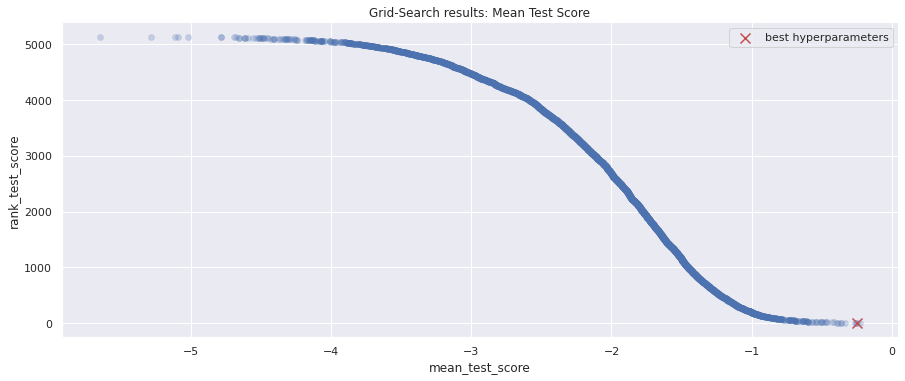

In [44]:
axs = sns.relplot(
    #kind='line',
    data=gs_df,
    x='mean_test_score', y='rank_test_score',
    aspect=2.5, ec='C0', alpha=.25
)
ax = axs.axes.flat[0]
ax.scatter(
    best_gs_res.mean_test_score, best_gs_res.rank_test_score, marker='x', s=100, color='r',
    label='best hyperparameters'
)
ax.set(
    title='Grid-Search results: Mean Test Score'
)
ax.legend()
plt.show()

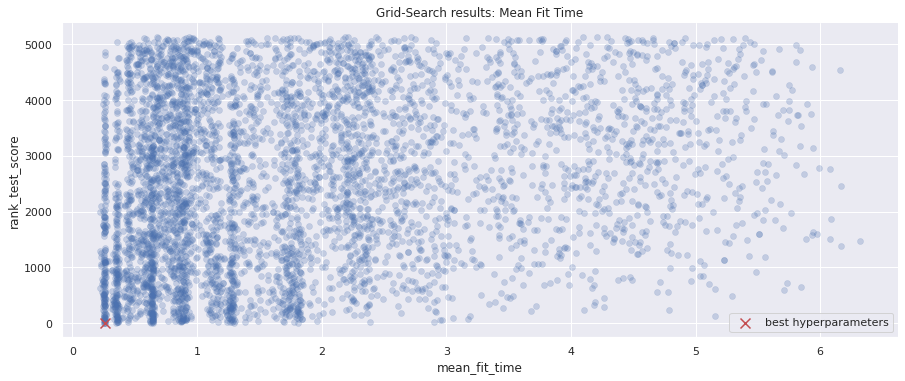

In [45]:
axs = sns.relplot(
    #kind='line',
    data=gs_df,
    x='mean_fit_time', y='rank_test_score',
    aspect=2.5, ec='C0', alpha=.25
)
ax = axs.axes.flat[0]
ax.scatter(
    best_gs_res.mean_fit_time, best_gs_res.rank_test_score, marker='x', s=100, color='r',
    label='best hyperparameters'
)
ax.set(
    title='Grid-Search results: Mean Fit Time'
)
ax.legend()
plt.show()

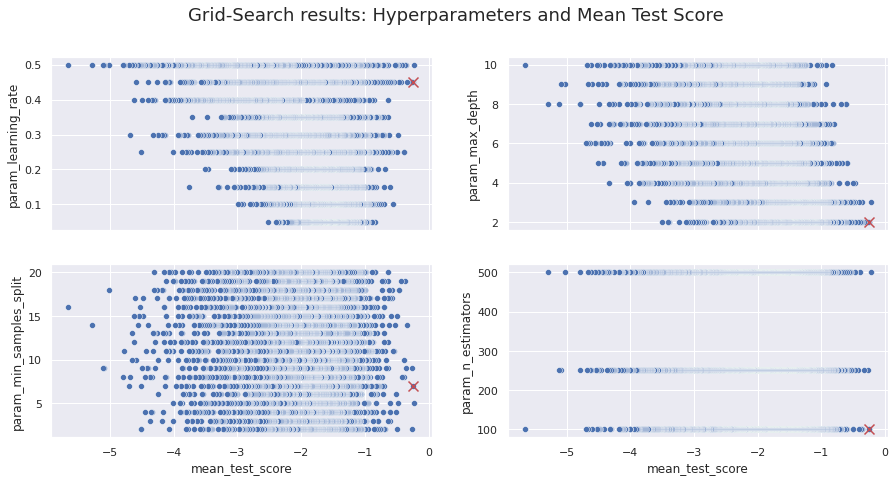

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
sns.scatterplot(
    data=gs_df,
    y='param_learning_rate', x='mean_test_score',
    ax=ax[0,0]
)
ax[0,0].scatter(best_gs.mean_test_score, best_gs.param_learning_rate, marker='x', s=100, color='r')
sns.scatterplot(
    data=gs_df,
    y='param_max_depth', x='mean_test_score',
    ax=ax[0,1]
)
ax[0,1].scatter(best_gs.mean_test_score, best_gs.param_max_depth, marker='x', s=100, color='r')
sns.scatterplot(
    data=gs_df,
    y='param_min_samples_split', x='mean_test_score',
    ax=ax[1,0]
)
ax[1,0].scatter(best_gs.mean_test_score, best_gs.param_min_samples_split, marker='x', s=100, color='r')
sns.scatterplot(
    data=gs_df,
    y='param_n_estimators', x='mean_test_score',
    ax=ax[1,1]
)
ax[1,1].scatter(best_gs.mean_test_score, best_gs.param_n_estimators, marker='x', s=100, color='r')
fig.suptitle('Grid-Search results: Hyperparameters and Mean Test Score', fontsize=18)
plt.show()

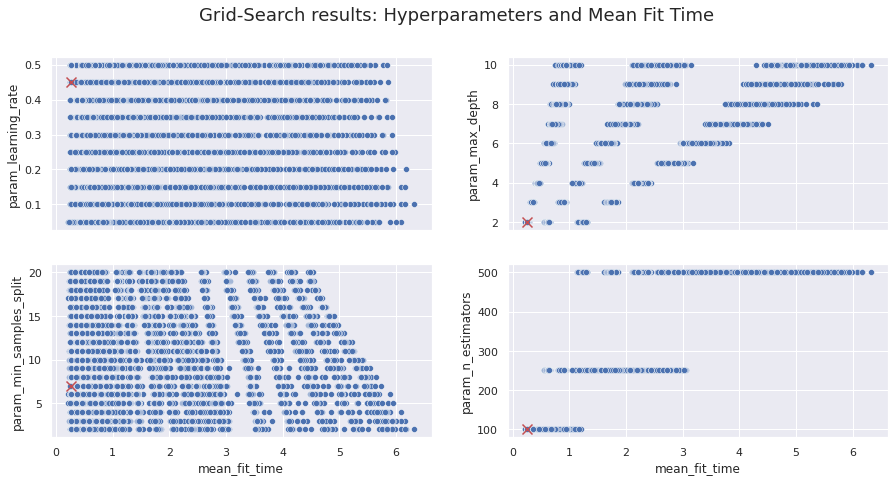

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
sns.scatterplot(
    data=gs_df,
    y='param_learning_rate', x='mean_fit_time',
    ax=ax[0,0]
)
ax[0,0].scatter(best_gs.mean_fit_time, best_gs.param_learning_rate, marker='x', s=100, color='r')
sns.scatterplot(
    data=gs_df,
    y='param_max_depth', x='mean_fit_time',
    ax=ax[0,1]
)
ax[0,1].scatter(best_gs.mean_fit_time, best_gs.param_max_depth, marker='x', s=100, color='r')
sns.scatterplot(
    data=gs_df,
    y='param_min_samples_split', x='mean_fit_time',
    ax=ax[1,0]
)
ax[1,0].scatter(best_gs.mean_fit_time, best_gs.param_min_samples_split, marker='x', s=100, color='r')
sns.scatterplot(
    data=gs_df,
    y='param_n_estimators', x='mean_fit_time',
    ax=ax[1,1]
)
ax[1,1].scatter(best_gs.mean_fit_time, best_gs.param_n_estimators, marker='x', s=100, color='r')
fig.suptitle('Grid-Search results: Hyperparameters and Mean Fit Time', fontsize=18)
plt.show()

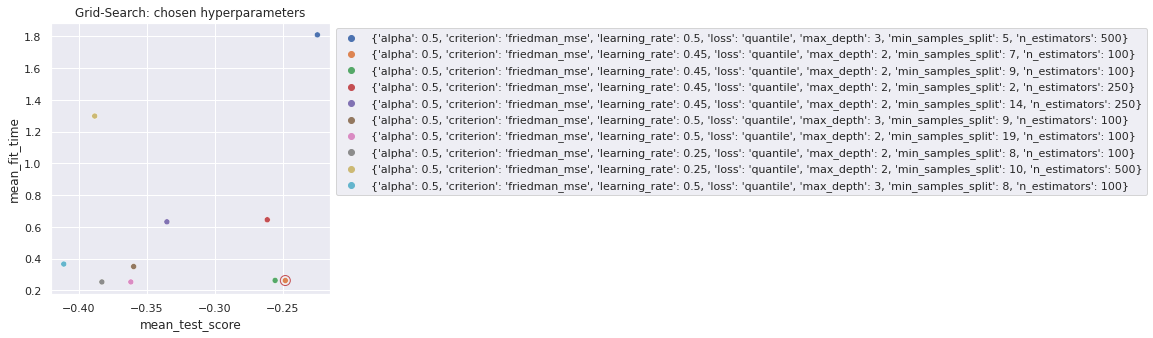

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=gs_res.sort_values(by='rank_test_score').head(10),
    y='mean_fit_time', x='mean_test_score',
    hue='params'
)
ax.scatter(best_gs_res.mean_test_score, best_gs_res.mean_fit_time, marker='o', fc='none', s=100, color='r')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Grid-Search: chosen hyperparameters')
plt.show()

In [49]:
gs_df_head = gs_df.head(10)

In [50]:
gs_df_head.columns = gs_df_head.columns.str.replace('param_', '')

In [51]:
gs_df_head

,alpha,criterion,learning_rate,loss,max_depth,min_samples_split,n_estimators,mean_test_score,rank_test_score,mean_fit_time
0,0.5,friedman_mse,0.50,quantile,3,5,500,-0.224477,1,1.808948
1,0.5,friedman_mse,0.45,quantile,2,7,100,-0.248057,2,0.262349
2,0.5,friedman_mse,0.45,quantile,2,9,100,-0.255568,3,0.263029
3,0.5,friedman_mse,0.45,quantile,2,2,250,-0.261327,4,0.644781
4,0.5,friedman_mse,0.45,quantile,2,14,250,-0.335137,5,0.631947
5,0.5,friedman_mse,0.50,quantile,3,9,100,-0.359586,6,0.350387
6,0.5,friedman_mse,0.50,quantile,2,19,100,-0.361650,7,0.253400
7,0.5,friedman_mse,0.25,quantile,2,8,100,-0.382944,8,0.253397
8,0.5,friedman_mse,0.25,quantile,2,10,500,-0.388231,9,1.297752
9,0.5,friedman_mse,0.50,quantile,3,8,100,-0.410970,10,0.366048


In [52]:
for mdl_param in GBR_params:
    print(mdl_param, ':', GBR_params[mdl_param])

alpha : 0.5
ccp_alpha : 0.0
criterion : friedman_mse
init : None
learning_rate : 0.45
loss : quantile
max_depth : 2
max_features : None
max_leaf_nodes : None
min_impurity_decrease : 0.0
min_impurity_split : None
min_samples_leaf : 1
min_samples_split : 7
min_weight_fraction_leaf : 0.0
n_estimators : 100
n_iter_no_change : None
random_state : None
subsample : 1.0
tol : 0.0001
validation_fraction : 0.1
verbose : 0
warm_start : False


Per l'intervallo di confidenza, è stato ottimizzato il modello anche con $\alpha$-quantile-loss di 0.25 e 0.75 oltre che 0.50, ripetendo l'ottimizzazione per $n$ iterazioni. I risultati sono stati concatenati e ne è stata stimata la distribuzione normale gaussiana dalla quale è stato scelto l'intervallo di confidenza al 99%.

Globalmente, si può ritenere pertanto un intervallo di confidenza del 50%.

Il coefficiente di determinazione $R^2$ di train e test è superiore a 0.90, indicando una buona correlazione tra osservazioni e previsioni.

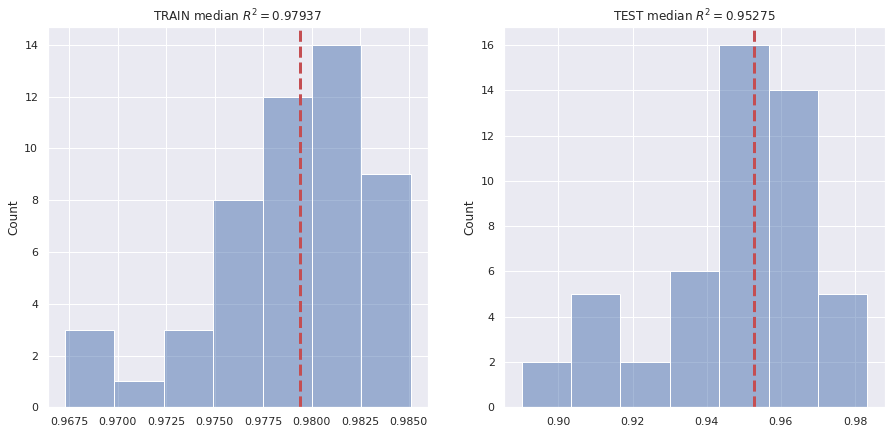

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(R2_train, alpha=.5, ax=ax[0])
ax[0].set(
    title=f"TRAIN median $R^2 = {np.median(R2_train):.5f}$"
)
ax[0].axvline(np.median(R2_train), color='r', ls='--', lw=3)
sns.histplot(R2_test, alpha=.5, ax=ax[1])
ax[1].set(
    title=f"TEST median $R^2 = {np.median(R2_test):.5f}$"
)
ax[1].axvline(np.median(R2_test), color='r', ls='--', lw=3)
plt.show()

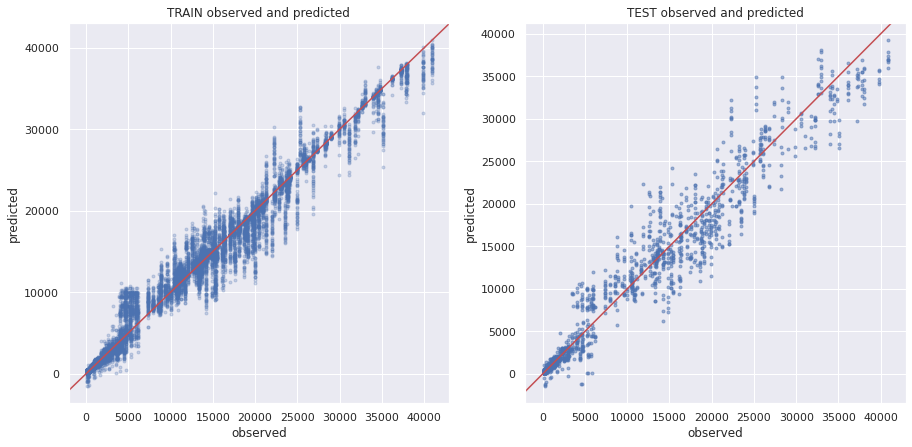

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(y_trains, y_trains_pred, marker='.', ls='none', color='C0', alpha=.25)
ax[0].axline(xy1=(0,0), slope=1, color='r')
ax[0].set(
    title='TRAIN observed and predicted',
    xlabel='observed', ylabel='predicted'
)
ax[1].plot(y_tests, y_tests_pred, marker='.', ls='none', color='C0', alpha=.5)
ax[1].axline(xy1=(0,0), slope=1, color='r')
ax[1].set(
    title='TEST observed and predicted',
    xlabel='observed', ylabel='predicted'
)
plt.show()

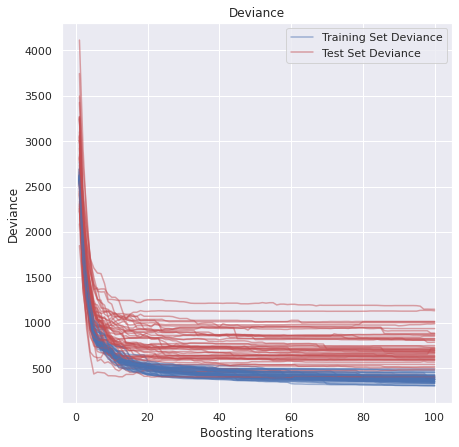

In [55]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Deviance')
for i in range(iterations):
    ax.plot(np.arange(n_estimators) + 1, train_scores[i], 'b-',
             alpha=.5,
             label='Training Set Deviance' if not i else None)
    ax.plot(np.arange(n_estimators) + 1, test_scores[i], 'r-',
             alpha=.5,
             label='Test Set Deviance' if not i else None)
ax.legend(loc='upper right')
ax.set_xlabel('Boosting Iterations')
ax.set_ylabel('Deviance')
plt.show()

In [56]:
feature_importance_df = pd.DataFrame(
    feature_importances,
    columns=[f'-{i}' for i in np.arange(1, 29)][::-1]
).melt()

permutation_importance_df = pd.DataFrame(
    permutation_imps.T,
    columns=[f'-{i}' for i in np.arange(1, 29)][::-1]
).melt()

L'importanza delle features dimostra come i nuovi positivi osservati il giorno precedente e 7 giorni prima abbiano un ruolo predominante nella previsione dei nuovi positivi futuri. Il risultato è compatibile con la forma del modello SARIMA.

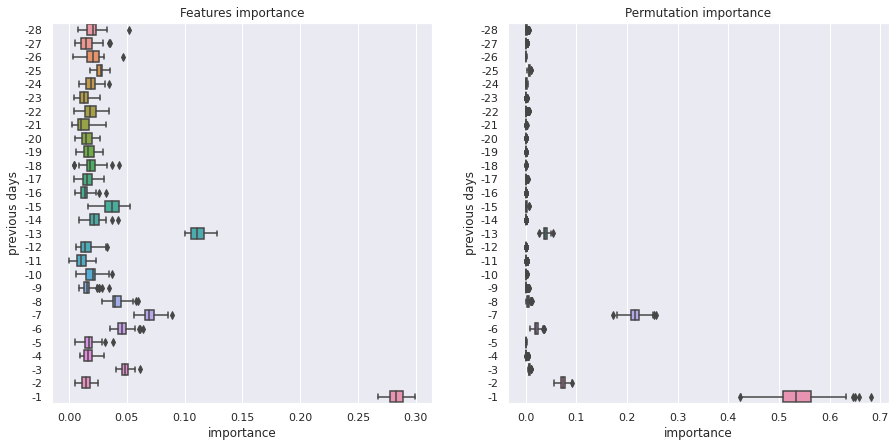

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.boxplot(
    data=feature_importance_df,
    x='value', y='variable',
    ax=ax[0],
)
ax[0].set(
    title='Features importance',
    ylabel='previous days',
    xlabel='importance'
)
sns.boxplot(
    data=permutation_importance_df,
    x='value', y='variable',
    ax=ax[1],
)
ax[1].set(
    title='Permutation importance',
    ylabel='previous days',
    xlabel='importance'
)
plt.show()